<a href="https://colab.research.google.com/github/yshahanov/Basic-Data-Visualization-prediction/blob/main/GoogLeNet_basic_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torch.utils.data import Subset
import random

from torchsummary import summary
import os
import pandas as pd
import pickle
from skimage import io
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
annotation_path = "/content/drive/My Drive/data/annotations.p"
image_path = "/content/drive/My Drive/data/crops"

with open(annotation_path, 'rb') as file:
  data = file.read()


annotaion_df = pickle.loads(data)


class CustomDataset(Dataset):
  def __init__(self, annotaion_frame, image_path, apply_transformations = None):
    self.annotaion_frame = annotaion_frame
    self.image_path = image_path
    self.apply_transformations = apply_transformations


  def __len__(self):
    return len(self.annotaion_frame) # > 19000

  def __getitem__(self, index):
    image_path = os.path.join(self.image_path, self.annotaion_frame.iloc[index, 0])
    image = io.imread(image_path)
    label = torch.tensor(int(self.annotaion_frame.iloc[index, 1]))


    if self.apply_transformations is not None:
      image = self.apply_transformations(image)


    return (image, label)




In [ ]:
# from torchvision.datasets import CIFAR10


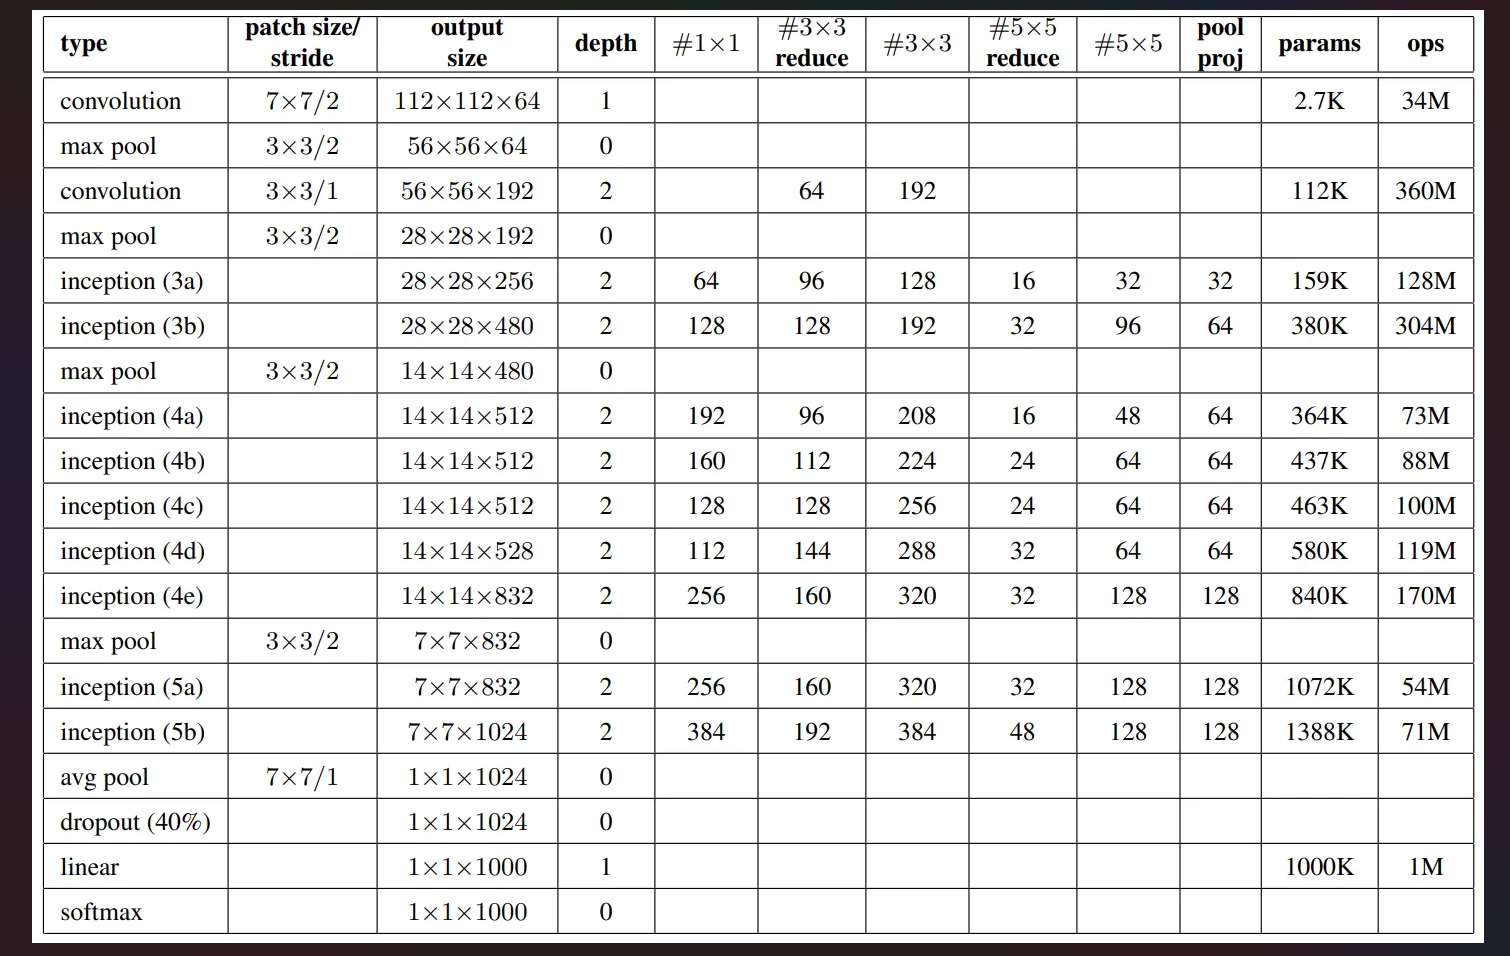

In [ ]:
# GoogLeNet CNN


class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvolutionalBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, num1x1, num3x3_reduce, num3x3, num5x5_reduce, num5x5, pool_proj,):
      super(InceptionBlock, self).__init__()

      self.l1 = nn.Sequential(
            ConvolutionalBlock(in_channels, num1x1, kernel_size=1, stride=1, padding=0)
        )

      self.l2 = nn.Sequential(
            ConvolutionalBlock(in_channels, num3x3_reduce, kernel_size=1, stride=1, padding=0),
            ConvolutionalBlock(num3x3_reduce, num3x3, kernel_size=3, stride=1, padding=1),)

      self.l3 = nn.Sequential(
            ConvolutionalBlock(in_channels, num5x5_reduce, kernel_size=1, stride=1, padding=0),
            ConvolutionalBlock(num5x5_reduce, num5x5, kernel_size=5, stride=1, padding=2),)

      self.l4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvolutionalBlock(in_channels, pool_proj, kernel_size=1, stride=1, padding=0),)


    def forward(self, x):
        # Note the different way this forward function
        # calculates the output.
        l1 = self.l1(x)
        l2 = self.l2(x)
        l3 = self.l3(x)
        l4 = self.l4(x)

        return torch.cat([l1, l2, l3, l4], 1)



class AuxiliaryTower(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(AuxiliaryTower, self).__init__()

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.activation = nn.ReLU()

        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)


    def forward(self, x):
        out = self.pool(x)

        out = self.conv(out)
        out = self.activation(out)
        # print('out shape is  ', out.shape)
        # out shape is  torch.Size([2, 128, 4, 4])

        out = torch.flatten(out, 1)

        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)

        return out

class InceptionV2(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionV2, self).__init__()

        self.conv1 = ConvolutionalBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvolutionalBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvolutionalBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception3A = InceptionBlock(in_channels=192, num1x1=64, num3x3_reduce=96, num3x3=128, num5x5_reduce=16, num5x5=32, pool_proj=32,)
        self.inception3B = InceptionBlock(in_channels=256, num1x1=128, num3x3_reduce=128, num3x3=192, num5x5_reduce=32, num5x5=96, pool_proj=64, )

        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception4A = InceptionBlock(in_channels=480, num1x1=192, num3x3_reduce=96, num3x3=208, num5x5_reduce=16, num5x5=48, pool_proj=64, )
        self.inception4B = InceptionBlock(in_channels=512, num1x1=160, num3x3_reduce=112, num3x3=224, num5x5_reduce=24, num5x5=64, pool_proj=64, )
        self.inception4C = InceptionBlock( in_channels=512, num1x1=128, num3x3_reduce=128, num3x3=256, num5x5_reduce=24, num5x5=64, pool_proj=64, )
        self.inception4D = InceptionBlock(in_channels=512, num1x1=112, num3x3_reduce=144, num3x3=288, num5x5_reduce=32, num5x5=64, pool_proj=64, )
        self.inception4E = InceptionBlock( in_channels=528, num1x1=256, num3x3_reduce=160, num3x3=320, num5x5_reduce=32, num5x5=128, pool_proj=128, )

        self.pool5 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)


        self.inception5A = InceptionBlock(in_channels=832, num1x1=256, num3x3_reduce=160, num3x3=320, num5x5_reduce=32, num5x5=128, pool_proj=128, )
        self.inception5B = InceptionBlock( in_channels=832, num1x1=384, num3x3_reduce=192, num3x3=384, num5x5_reduce=48, num5x5=128, pool_proj=128, )

        self.pool6 = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        self.aux4A = AuxiliaryTower(512, num_classes)
        self.aux4D = AuxiliaryTower(528, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.pool3(out)
        out = self.inception3A(out)
        out = self.inception3B(out)
        out = self.pool4(out)
        out = self.inception4A(out)

        aux1 = self.aux4A(out)

        out = self.inception4B(out)
        out = self.inception4C(out)
        out = self.inception4D(out)

        aux2 = self.aux4D(out)

        out = self.inception4E(out)
        out = self.pool5(out)
        out = self.inception5A(out)
        out = self.inception5B(out)
        out = self.pool6(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)

        return out, aux1, aux2



In [ ]:
# import torch.nn.init as init

# def initialize_weights(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         init.xavier_uniform_(m.weight)
#         if m.bias is not None:
#             init.constant_(m.bias, 0)

# batch_size = 32
# num_epochs = 10


model = InceptionV2()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

print(summary(model, (3, 256, 256)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,472
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
ConvolutionalBlock-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]           4,160
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
ConvolutionalBlock-9           [-1, 64, 64, 64]               0
           Conv2d-10          [-1, 192, 64, 64]         110,784
      BatchNorm2d-11          [-1, 192, 64, 64]             384
             ReLU-12          [-1, 192, 64, 64]               0
ConvolutionalBlock-13          [-1, 192, 64, 64]               0
        MaxPool2d-14          [-1, 192

In [ ]:
# # # DATASET CIFAR 10 testing
# transform = transforms.Compose([
#     transforms.ToTensor(),
#       transforms.Resize((224, 224), antialias=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensors
# ]) #  transforms.Resize((224, 224), antialias=True),


# train_dataset = CIFAR10(root='./drive/MyDrive/data', train=True, download=True, transform=transform)
# val_dataset = CIFAR10(root='./drive/MyDrive/data', train=False, download=True, transform=transform)

# # converting to tensor
# train_dataset.targets = torch.tensor(train_dataset.targets)
# val_dataset.targets = torch.tensor(val_dataset.targets)

# subset_size = 7000
# subset_indices = random.sample(range(len(train_dataset)), subset_size)
# subset_dataset = Subset(train_dataset, subset_indices)

# val_subset_size = 3000
# val_subset_indices = random.sample(range(len(val_dataset)), val_subset_size)
# val_subset_dataset = Subset(val_dataset, val_subset_indices)

# cs = DataLoader(subset_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_subset_dataset, batch_size=32)

# train_dataset[0][0]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
      transforms.Resize((224, 224), antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

custom_dataset = CustomDataset(annotaion_df, image_path, apply_transformations = transform)


dataset_size = len(custom_dataset)

train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])


train_dataloader_cells = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader_cells = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader_cells = DataLoader(test_dataset, batch_size=32, shuffle=True)



In [ ]:
# inception.train()


print(f"Device in use: {device}")
loss_func = nn.CrossEntropyLoss()

loss_func = loss_func.to(torch.device("cuda"))

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 5

training = 0
if training:
  for epoch in range(num_epochs):
      running_loss = 0.0

      progress_bar = tqdm.tqdm(train_dataloader_cells, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
      # train loop
      for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs, aux1, aux2 = model(inputs)

        loss = loss_func(outputs, labels)
        aux_tower1_loss = loss_func(aux1, labels)
        aux_tower2_loss = loss_func(aux2, labels)

        total_loss = loss + 0.3 * aux_tower1_loss + 0.3 * aux_tower2_loss
        total_loss.backward()

        optimizer.step()

        running_loss += total_loss.item()

        progress_bar.set_postfix(loss=loss.item())

      average_loss = running_loss / len(train_dataloader_cells)
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

      # val loop
      validation_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():

          val_progress_bar = tqdm.tqdm(val_dataloader_cells, desc=f"Validation Epoch {epoch+1}/{num_epochs}", leave=False)

          for val_inputs, val_labels in val_progress_bar:
              val_inputs = val_inputs.to(device)
              val_labels = val_labels.to(device)

              val_outputs, _, _ = model(val_inputs)

              val_loss = loss_func(val_outputs, val_labels)
              validation_loss += val_loss.item()

              _, predicted = torch.max(val_outputs.data, 1)
              total += val_labels.size(0)
              correct += (predicted == val_labels).sum().item()

      validation_loss /= len(val_dataloader_cells)
      accuracy = 100 * correct / total

      print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%")



Device in use: cuda


In [ ]:
model_path = "/content/drive/MyDrive/trained_model_GoogLeNet(inception).pth"
torch.save(model.state_dict(), model_path)
print(f"Trained model saved at {model_path}")



Trained model saved at /content/drive/MyDrive/trained_model_GoogLeNet(inception).pth


In [ ]:
model = InceptionV2()
model.load_state_dict(torch.load(model_path))
model.to(device)
test_loss = 0.0
correct = 0
total = 0


In [ ]:
# model = InceptionV2()
# model.load_state_dict(torch.load(model_path))
# model.t
test_loss = 0.0
correct = 0
total = 0


true_labels = []
predicted_labels = []
accuracies = []


testing = 0
if testing:
  with torch.no_grad():
      model.eval()
      test_loss = 0.0
      correct = 0
      total = 0



      for test_inputs, test_labels in test_dataloader_cells:
          test_inputs = test_inputs.to(device)
          test_labels = test_labels.to(device)

          test_outputs, _, _ = model(test_inputs)

          test_loss += loss_func(test_outputs, test_labels).item()

          _, predicted = torch.max(test_outputs.data, 1)
          total += test_labels.size(0)
          correct += (predicted == test_labels).sum().item()
          true_labels.append(test_labels)
          predicted_labels.append(predicted)

      test_loss /= len(test_dataloader_cells)
      accuracy = 100 * correct / total

      accuracies.append(accuracy)
      print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")



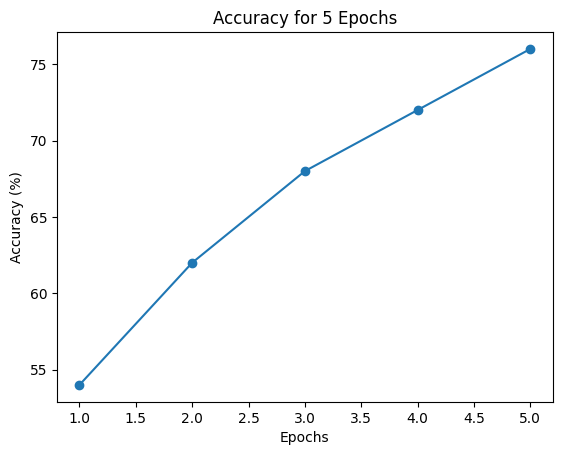

In [ ]:
import matplotlib.pyplot as plt


accuracies = [54, 62, 68, 72, 76]

epochs = range(1, len(accuracies) + 1)
plt.plot(epochs, accuracies, marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for 5 Epochs')

plt.show()
